In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
df_neg_pi_mc = pd.read_parquet("k0s/pp/neg_pi_eff_df_mc.parquet", engine="pyarrow") 
df_pos_pi_mc = pd.read_parquet("k0s/pp/pos_pi_eff_df_mc.parquet", engine="pyarrow") 
df_neg_pi = pd.read_parquet("k0s/pp/neg_pi_eff_df.parquet", engine="pyarrow") 
df_pos_pi = pd.read_parquet("k0s/pp/pos_pi_eff_df.parquet", engine="pyarrow") 

In [3]:
df_neg_pi.columns

Index(['fOccupancyFt0c', 'fPt', 'fNSigmaTpcPosPi', 'fNSigmaTpcPosPi_unc',
       'fNSigmaTpcNegPi', 'fNSigmaTpcNegPi_unc', 'fNSigmaTofPosPi',
       'fNSigmaTofPosPi_unc', 'fNSigmaTofNegPi', 'fNSigmaTofNegPi_unc',
       'fNSigmaTofPosPi_mean', 'fNSigmaTofPosPi_std', 'fNSigmaTofNegPi_mean',
       'fNSigmaTofNegPi_std', 'fNSigmaTpcPosPi_mean', 'fNSigmaTpcPosPi_std',
       'fNSigmaTpcNegPi_mean', 'fNSigmaTpcNegPi_std'],
      dtype='object')

In [4]:
def convert_to_interval(interval_str):
    match = re.match(r"(\[|\()(\d+(\.\d+)?),\s*(\d+(\.\d+)?)(\]|\))", interval_str)
    if match:
        # Extract the left and right bounds, converting them to float
        left = float(match.group(2))  # Group 2 captures the left bound
        right = float(match.group(4))  # Group 4 captures the right bound
        
        # Determine if the interval is closed on the left or right
        closed = 'left' if match.group(1) == '[' else 'right'
        # Return the interval as a pandas Interval
        return pd.Interval(left, right, closed=closed)
    
    # If the string doesn't match the interval format, return None
    return None  

def sort_df_by_interval(df, col):
    # Use .loc[] to safely modify the DataFrame and avoid the SettingWithCopyWarning
    df.loc[:, "lower_bound"] = df[col].apply(lambda x: x.left)  # Extract left bound
    df_sorted = df.sort_values("lower_bound").drop(columns="lower_bound")  # Sort and drop helper column
    return df_sorted

def get_label(diff_col_name):
    if diff_col_name == "fPt":
        return '$p_T$ (GeV/$c$)'
    if diff_col_name == "fOccupancyFt0c":
        return 'Occupancy FTOC (arb. units)'
    if diff_col_name == "fCentralityFT0C" or diff_col_name == "fCentralityFT0M":
        return 'Centrality'

In [5]:
interval_cols = ['fOccupancyFt0c', 'fPt']

for col in interval_cols:
    df_neg_pi_mc[col] = df_neg_pi_mc[col].apply(convert_to_interval) 
    df_pos_pi_mc[col] = df_pos_pi_mc[col].apply(convert_to_interval) 
    df_neg_pi[col] = df_neg_pi[col].apply(convert_to_interval) 
    df_pos_pi[col] = df_pos_pi[col].apply(convert_to_interval)

In [6]:
def draw_means(dfs_mc, leg_entries, diff_col_name, labels, eff_var):
        
    sort_dfs_data, sort_dfs_mc = [], []
    for df_mc in dfs_mc:
        sort_dfs_mc.append(sort_df_by_interval(df_mc, diff_col_name))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    lower_bin_bounds = sort_dfs_mc[0][diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_dfs_mc[0][diff_col_name].apply(lambda x: x.right)
    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    ticks = list(lower_bin_bounds) + [list(upper_bin_bounds)[-1]]
    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(ticks, rotation=45, ha='right')
    for df, label in zip(sort_dfs_mc, labels):
        axs[0].errorbar(bin_centers, df[f"{eff_var}_mean"],
                        xerr=bin_widths, label=label, fmt='p')
    axs[0].set_xlabel(get_label(diff_col_name))
    axs[0].set_ylabel('Mean')
    axs[0].legend()
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(ticks, rotation=45, ha='right')
    ratios = [np.array(df[f"{eff_var}_mean"]) / np.array(sort_dfs_mc[0][f"{eff_var}_mean"]) for df in sort_dfs_mc[1:]]
    for i_ratio, ratio in enumerate(ratios):
        axs[1].errorbar(bin_centers, ratio, c=f'C{i_ratio+1}',
                        xerr=bin_widths, label=label, fmt='p')
    axs[1].set_xlabel(get_label(diff_col_name))
    axs[1].set_ylabel(f'Ratio to {labels[0]}') 
    axs[1].axhline(y=1, color='k', linestyle='--')
    plt.show()

In [7]:
def draw_std(dfs_mc, leg_entries, diff_col_name, labels, eff_var):
        
    sort_dfs_data, sort_dfs_mc = [], []
    for df_mc in dfs_mc:
        sort_dfs_mc.append(sort_df_by_interval(df_mc, diff_col_name))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    lower_bin_bounds = sort_dfs_mc[0][diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_dfs_mc[0][diff_col_name].apply(lambda x: x.right)
    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    ticks = list(lower_bin_bounds) + [list(upper_bin_bounds)[-1]]
    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(ticks, rotation=45, ha='right')
    for df, label in zip(sort_dfs_mc, labels):
        axs[0].errorbar(bin_centers, df[f"{eff_var}_std"],
                        xerr=bin_widths, label=label, fmt='p')
    axs[0].set_xlabel(get_label(diff_col_name))
    axs[0].set_ylabel('RMS')
    axs[0].legend()
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(ticks, rotation=45, ha='right')
    ratios = [np.array(df[f"{eff_var}_std"]) / np.array(sort_dfs_mc[0][f"{eff_var}_std"]) for df in sort_dfs_mc[1:]]
    for i_ratio, ratio in enumerate(ratios):
        axs[1].errorbar(bin_centers, ratio, c=f'C{i_ratio+1}',
                        xerr=bin_widths, label=label, fmt='p')
    axs[1].set_xlabel(get_label(diff_col_name))
    axs[1].set_ylabel(f'Ratio to {labels[0]}') 
    axs[1].axhline(y=1, color='k', linestyle='--')
    plt.show()

In [8]:
def draw_ratio_sigma_pos_neg(dfs_pos, dfs_neg, leg_entries, diff_col_name, labels, var_pos, var_neg):
    cmap = plt.get_cmap('tab20')
    sort_dfs_pos, sort_dfs_neg = [], []
    for df_pos in dfs_pos:
        sort_dfs_pos.append(sort_df_by_interval(df_pos, diff_col_name))
    for df_neg in dfs_neg:
        sort_dfs_neg.append(sort_df_by_interval(df_neg, diff_col_name))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    lower_bin_bounds = sort_dfs_pos[0][diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_dfs_pos[0][diff_col_name].apply(lambda x: x.right)
    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    ticks = list(lower_bin_bounds) + [list(upper_bin_bounds)[-1]]
    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(ticks, rotation=45, ha='right')
    for i_df, (df_pos, df_neg, label) in enumerate(zip(sort_dfs_pos, sort_dfs_neg, labels)):
        axs[0].errorbar(bin_centers, df_pos[f"{var_pos}_std"], c=cmap(i_df*2),
                        xerr=bin_widths, label=f"{label}, positive", fmt='p')
        axs[0].errorbar(bin_centers, df_neg[f"{var_neg}_std"], c=cmap(i_df*2+1),
                        xerr=bin_widths, label=f"{label}, negative", fmt='p')
    axs[0].set_xlabel(get_label(diff_col_name))
    axs[0].set_ylabel('RMS')
    axs[0].legend()
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(ticks, rotation=45, ha='right')
    ratios = [np.array(df_pos[f"{var_pos}_std"]) / np.array(df_neg[f"{var_neg}_std"]) for df_pos, df_neg in zip(sort_dfs_pos, sort_dfs_neg)]
    for i_ratio, ratio in enumerate(ratios):
        axs[1].errorbar(bin_centers, ratio, c=cmap(i_ratio*2),
                        xerr=bin_widths, label=label, fmt='p')
    axs[1].set_xlabel(get_label(diff_col_name))
    axs[1].set_ylabel('Positive/Negative') 
    axs[1].axhline(y=1, color='k', linestyle='--')
    plt.show()

In [9]:
def draw_ratio_mean_pos_neg(dfs_pos, dfs_neg, leg_entries, diff_col_name, labels, var_pos, var_neg):
    cmap = plt.get_cmap('tab20')
    sort_dfs_pos, sort_dfs_neg = [], []
    for df_pos in dfs_pos:
        sort_dfs_pos.append(sort_df_by_interval(df_pos, diff_col_name))
    for df_neg in dfs_neg:
        sort_dfs_neg.append(sort_df_by_interval(df_neg, diff_col_name))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    lower_bin_bounds = sort_dfs_pos[0][diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_dfs_pos[0][diff_col_name].apply(lambda x: x.right)
    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    ticks = list(lower_bin_bounds) + [list(upper_bin_bounds)[-1]]
    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(ticks, rotation=45, ha='right')
    for i_df, (df_pos, df_neg, label) in enumerate(zip(sort_dfs_pos, sort_dfs_neg, labels)):
        axs[0].errorbar(bin_centers, df_pos[f"{var_pos}_mean"], c=cmap(i_df*2),
                        xerr=bin_widths, label=f"{label}, positive", fmt='p')
        axs[0].errorbar(bin_centers, df_neg[f"{var_neg}_mean"], c=cmap(i_df*2+1),
                        xerr=bin_widths, label=f"{label}, negative", fmt='p')
    axs[0].set_xlabel(get_label(diff_col_name))
    axs[0].set_ylabel('Mean')
    axs[0].legend()
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(ticks, rotation=45, ha='right')
    diffs = [np.array(df_pos[f"{var_pos}_mean"]) - np.array(df_neg[f"{var_neg}_mean"]) for df_pos, df_neg in zip(sort_dfs_pos, sort_dfs_neg)]
    for i_ratio, ratio in enumerate(diffs):
        axs[1].errorbar(bin_centers, ratio, c=cmap(i_ratio*2),
                        xerr=bin_widths, label=label, fmt='p')
    axs[1].set_xlabel(get_label(diff_col_name))
    axs[1].set_ylabel('Positive - Negative') 
    axs[1].axhline(y=0, color='k', linestyle='--')
    plt.show()

In [10]:
occ_bins = [0, 4000, 6000, 8000, 100000]
labels = [f'{occ_min} < Occupancy < {occ_max}' for occ_min, occ_max in zip(occ_bins[:-1], occ_bins[1:])]

occ_dfs_pos_pi_mc = [df_pos_pi_mc.query(f'fOccupancyFt0c == @pd.Interval({occ_min}, {occ_max}, closed="left")').reset_index(drop=True) for occ_min, occ_max in zip(occ_bins[:-1], occ_bins[1:])]
occ_dfs_pos_pi = [df_pos_pi.query(f'fOccupancyFt0c == @pd.Interval({occ_min}, {occ_max}, closed="left")').reset_index(drop=True) for occ_min, occ_max in zip(occ_bins[:-1], occ_bins[1:])]
occ_dfs_neg_pi_mc = [df_neg_pi_mc.query(f'fOccupancyFt0c == @pd.Interval({occ_min}, {occ_max}, closed="left")').reset_index(drop=True) for occ_min, occ_max in zip(occ_bins[:-1], occ_bins[1:])]
occ_dfs_neg_pi = [df_neg_pi.query(f'fOccupancyFt0c == @pd.Interval({occ_min}, {occ_max}, closed="left")').reset_index(drop=True) for occ_min, occ_max in zip(occ_bins[:-1], occ_bins[1:])]

## Negative pion

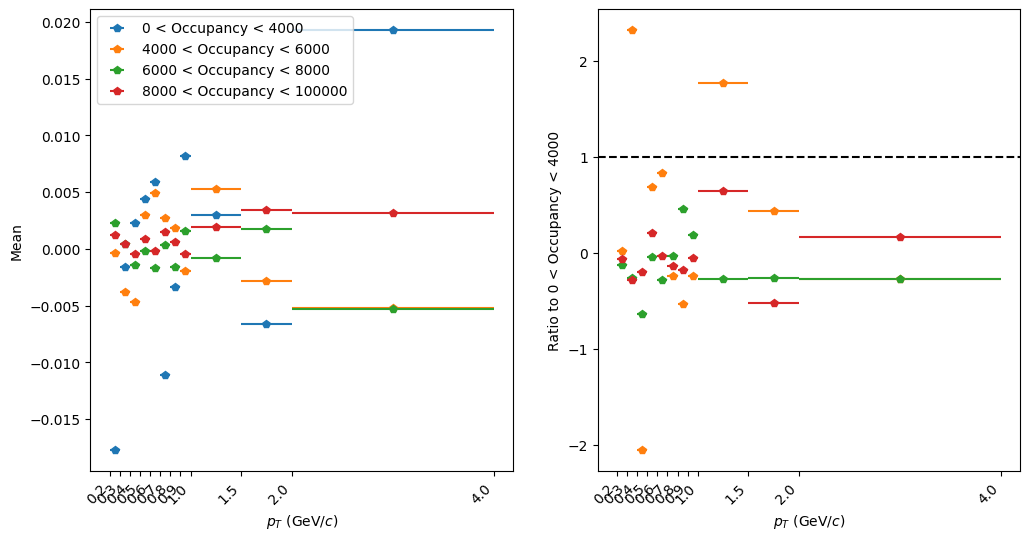

In [11]:
fig_occ_neg_pi = draw_means(occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcNegPi')

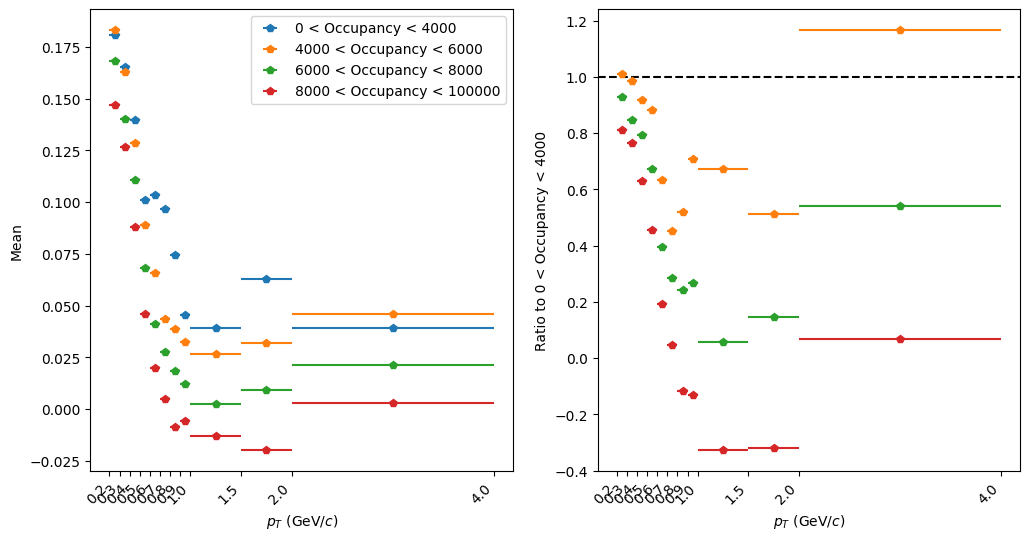

In [12]:
fig_occ_neg_pi = draw_means(occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcNegPi')

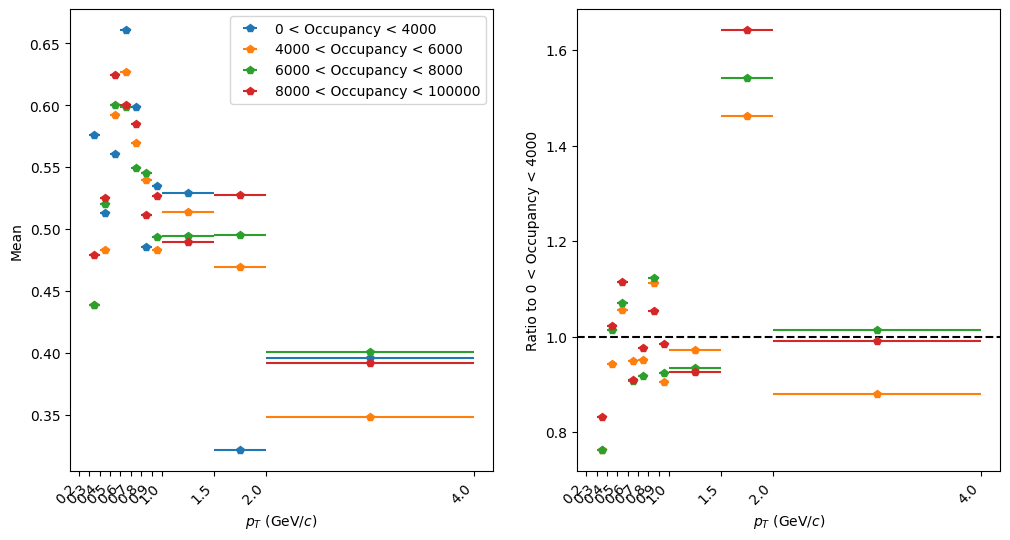

In [13]:
fig_occ_neg_pi = draw_means(occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofNegPi')

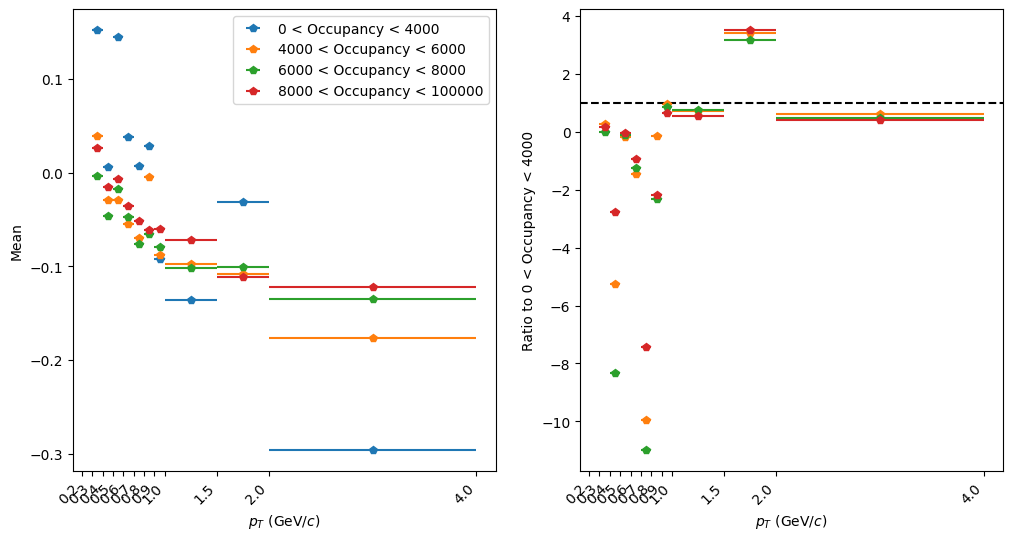

In [14]:
fig_occ_neg_pi = draw_means(occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofNegPi')

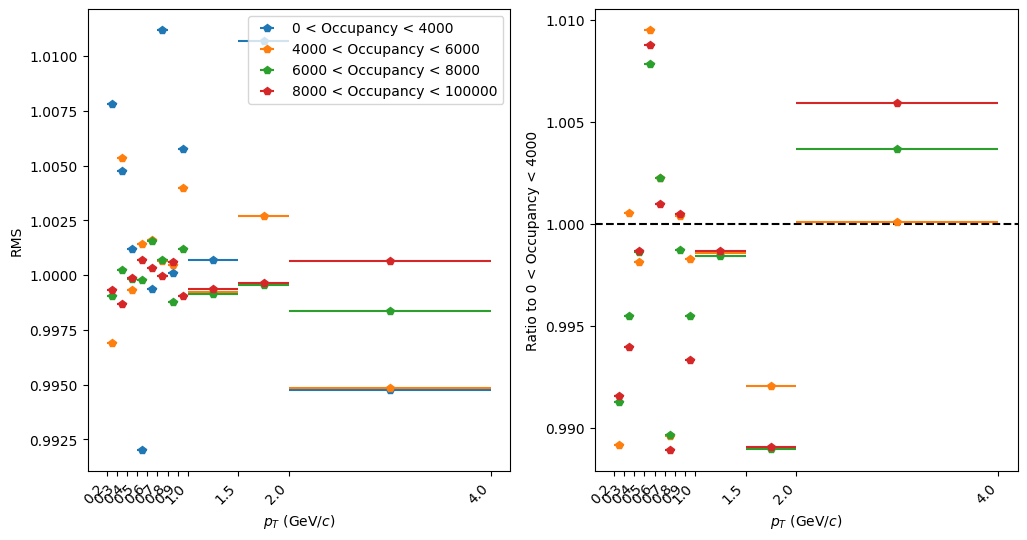

In [15]:
fig_occ_neg_pi = draw_std(occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcNegPi')

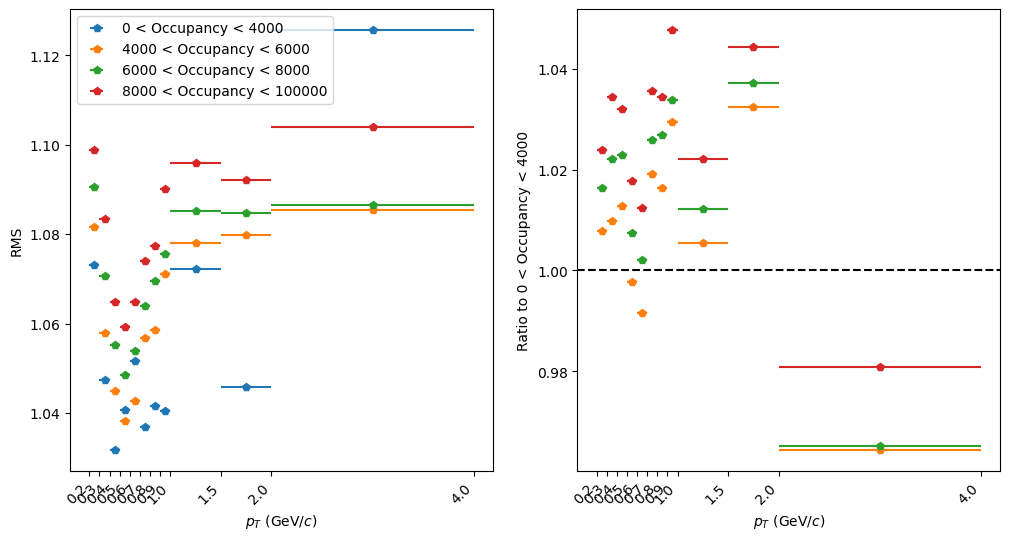

In [16]:
fig_occ_neg_pi = draw_std(occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcNegPi')

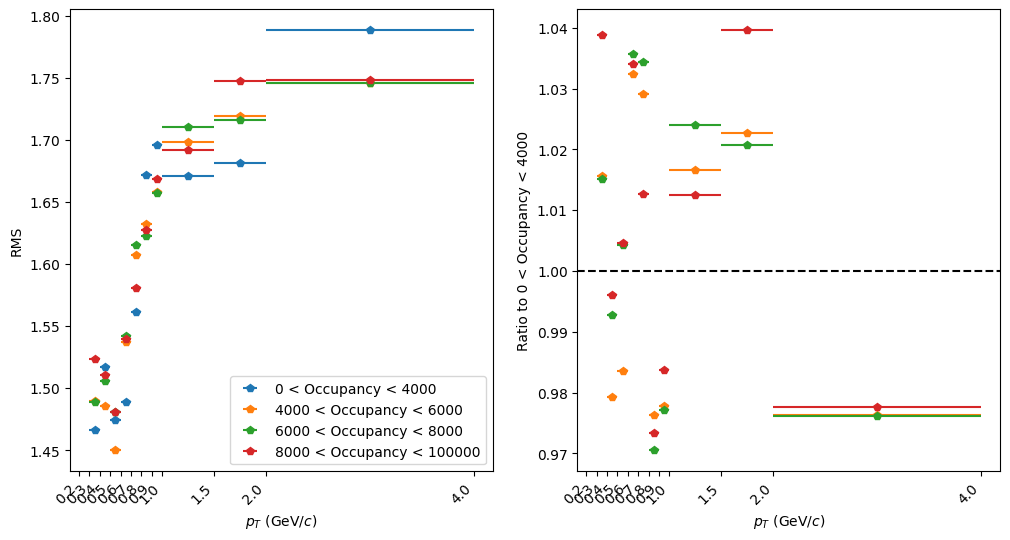

In [17]:
fig_occ_neg_pi = draw_std(occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofNegPi')

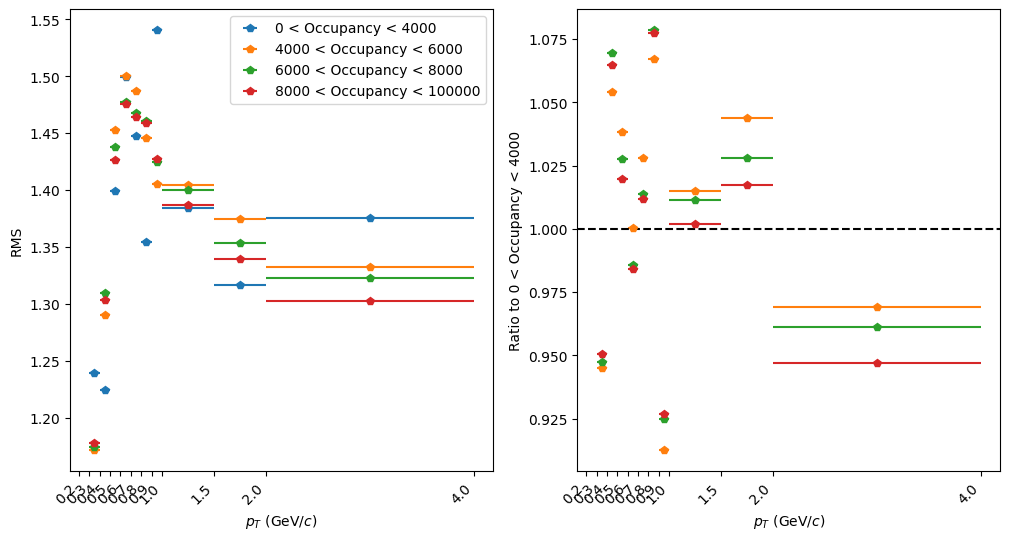

In [18]:
fig_occ_neg_pi = draw_std(occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofNegPi')

## Positive pion

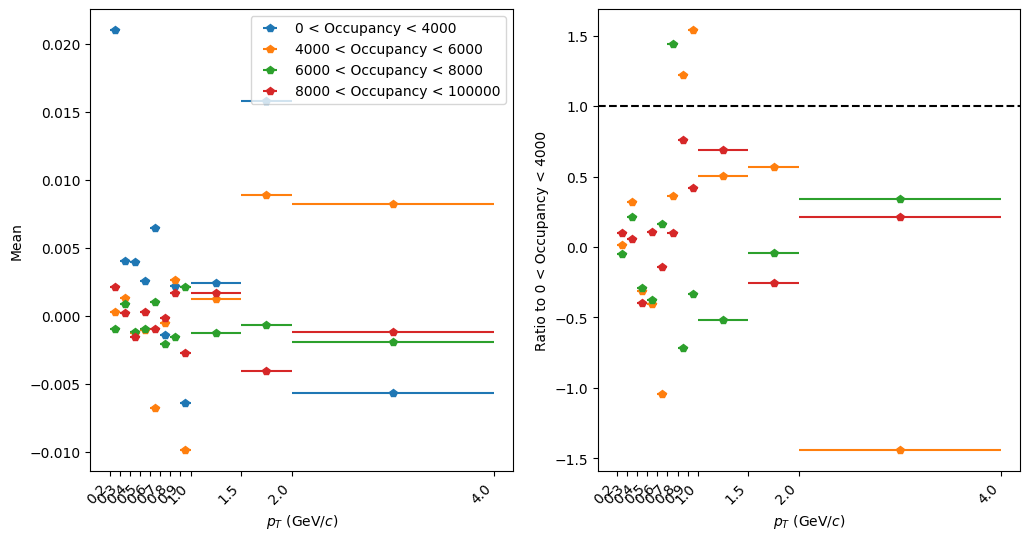

In [19]:
fig_occ_pos_pi = draw_means(occ_dfs_pos_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi')

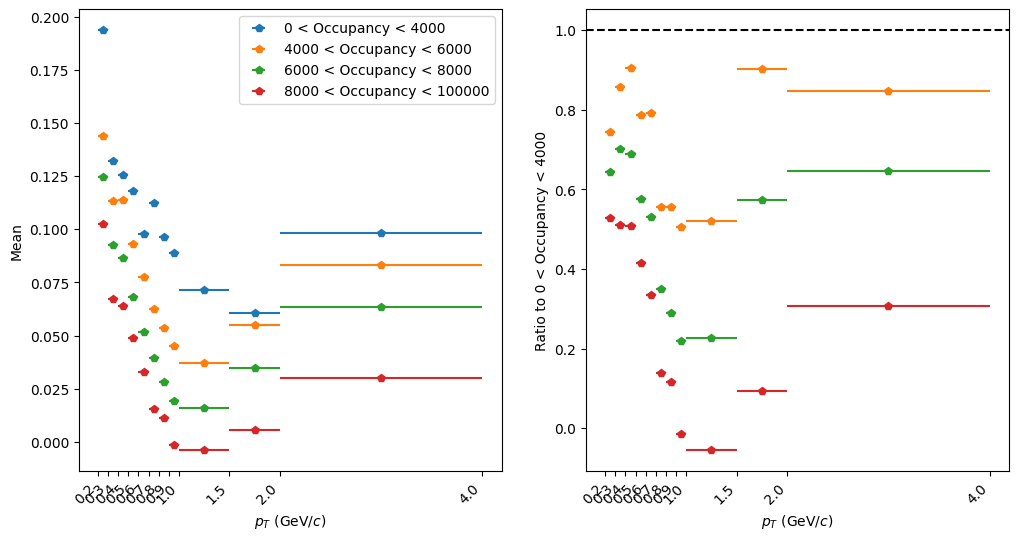

In [20]:
fig_occ_pos_pi = draw_means(occ_dfs_pos_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi')

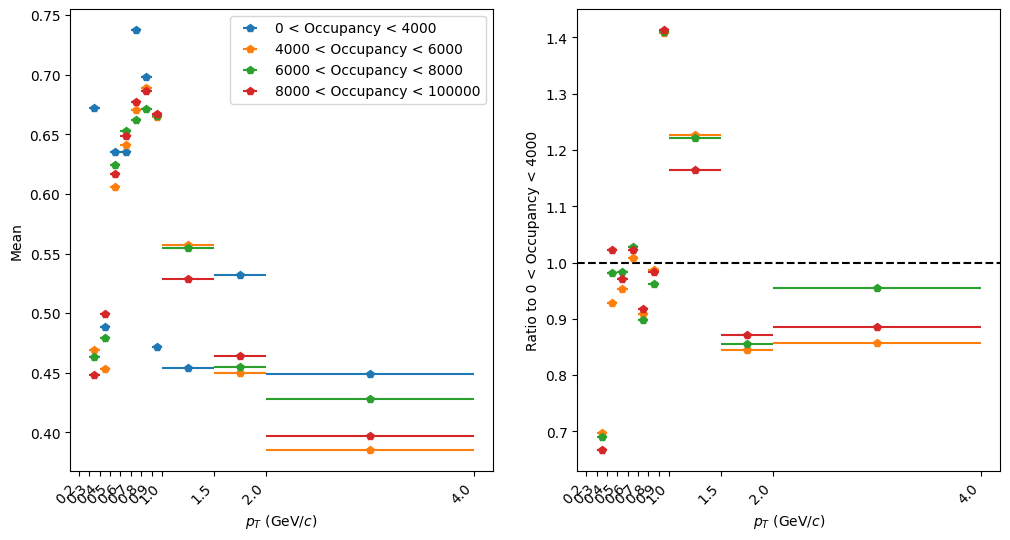

In [21]:
fig_occ_pos_pi = draw_means(occ_dfs_pos_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi')

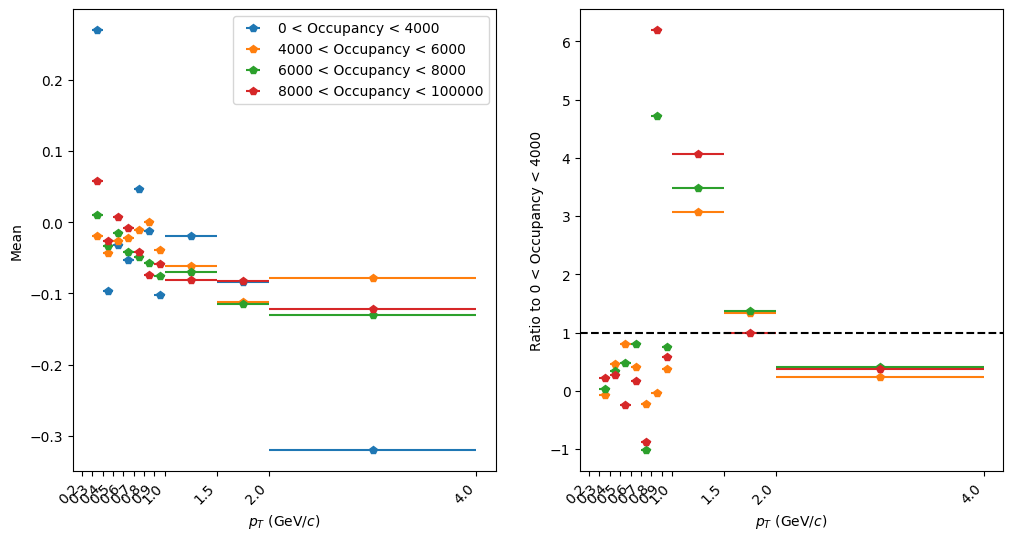

In [22]:
fig_occ_pos_pi = draw_means(occ_dfs_pos_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi')

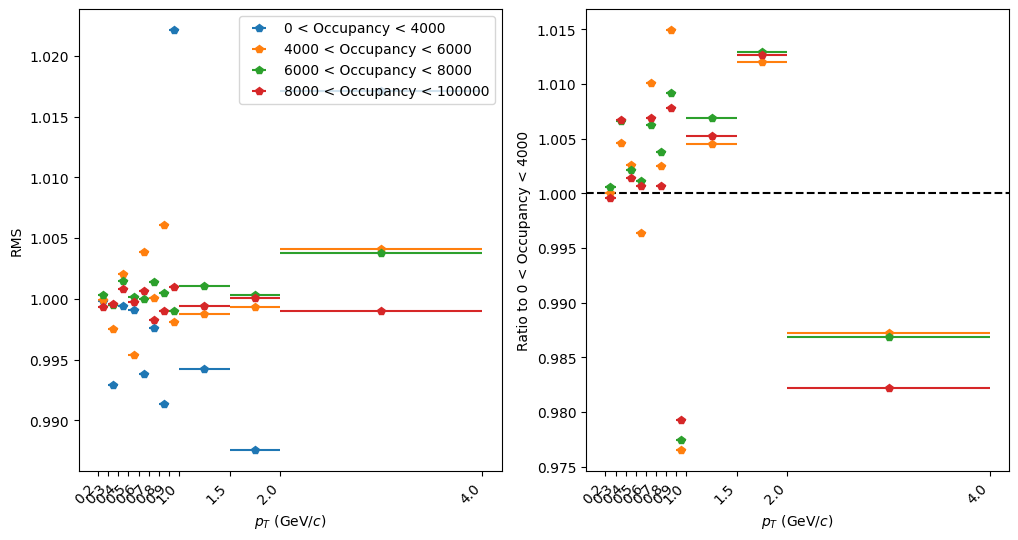

In [23]:
fig_occ_pos_pi = draw_std(occ_dfs_pos_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi')

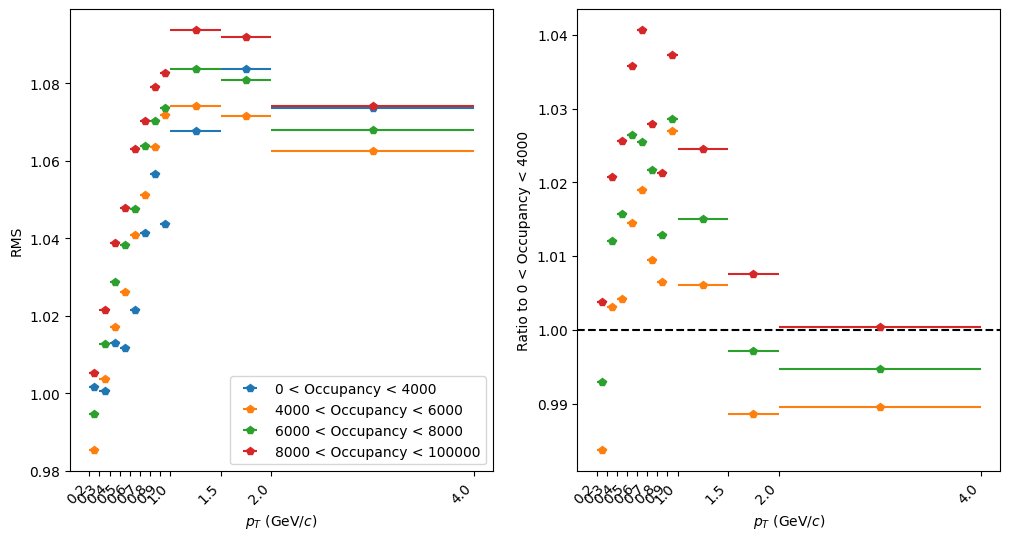

In [24]:
fig_occ_pos_pi = draw_std(occ_dfs_pos_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi')

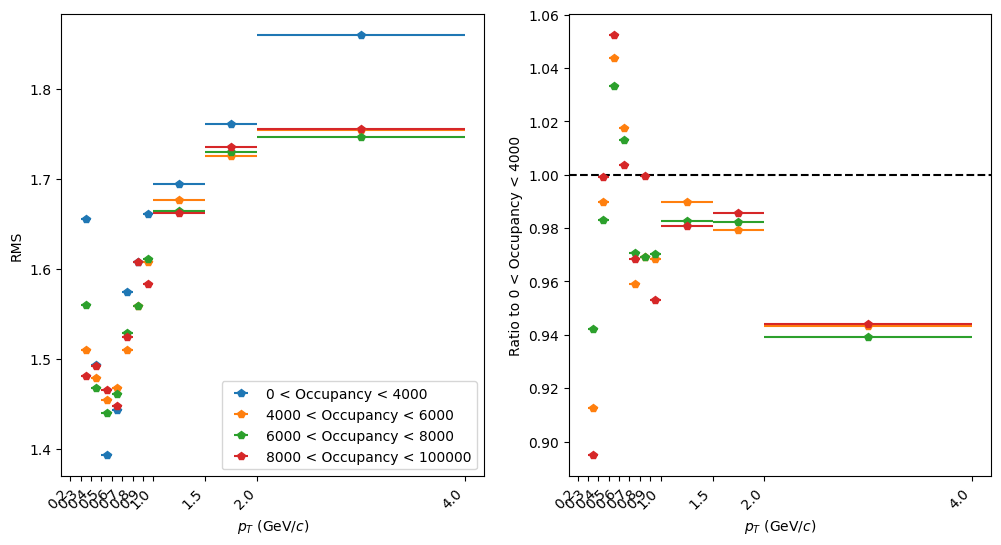

In [25]:
fig_occ_pos_pi = draw_std(occ_dfs_pos_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi')

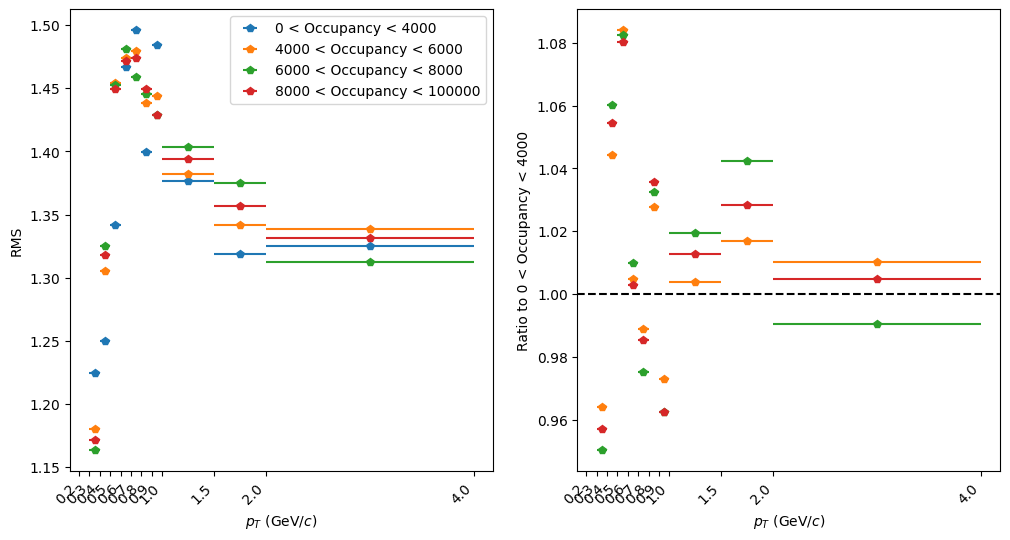

In [26]:
fig_occ_pos_pi = draw_std(occ_dfs_pos_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi')

## Positive/Negative

### Mean

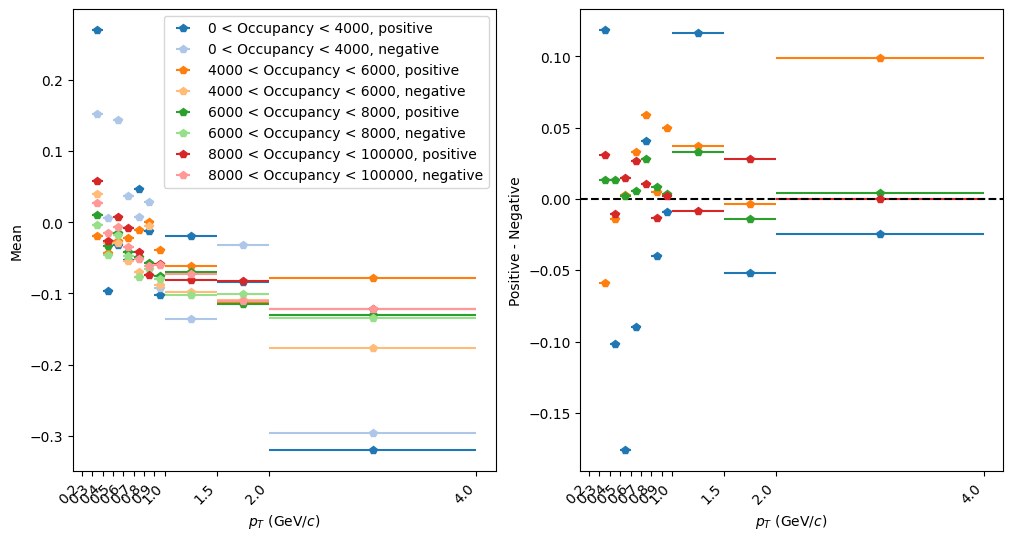

In [27]:
fig_occ_pos_pi = draw_ratio_mean_pos_neg(occ_dfs_pos_pi_mc, occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi', 'fNSigmaTofNegPi')

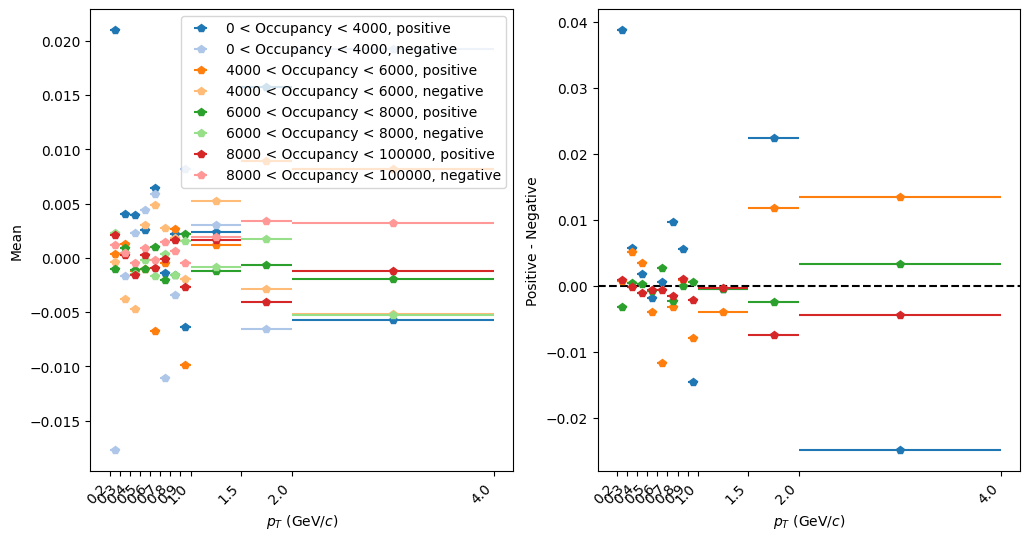

In [28]:
fig_occ_pos_pi = draw_ratio_mean_pos_neg(occ_dfs_pos_pi_mc, occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi', 'fNSigmaTpcNegPi')

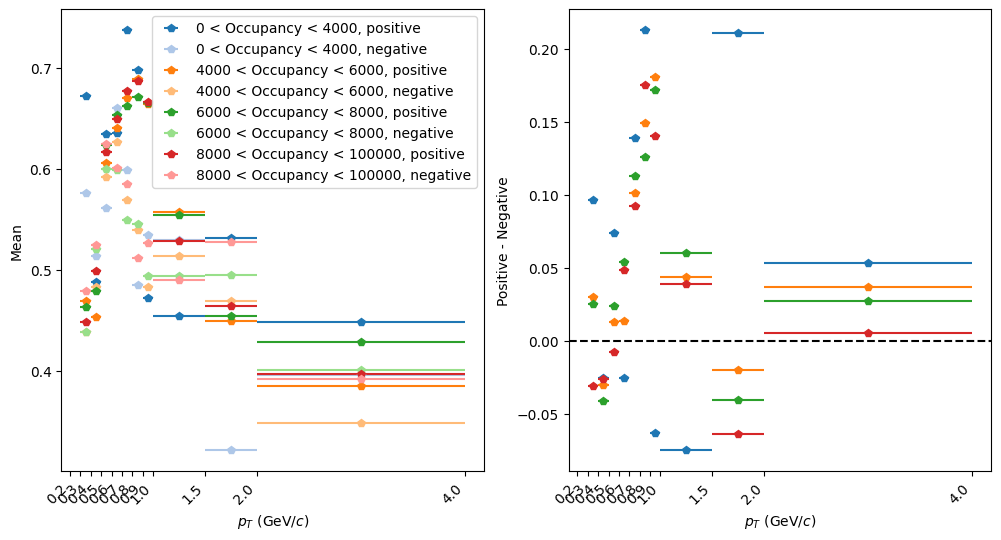

In [29]:
fig_occ_pos_pi = draw_ratio_mean_pos_neg(occ_dfs_pos_pi, occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi', 'fNSigmaTofNegPi')

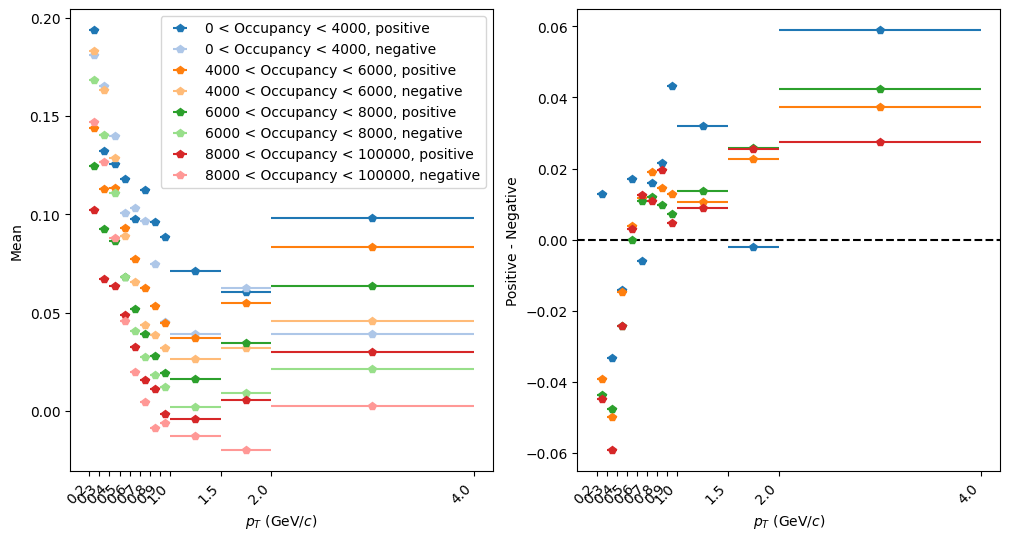

In [30]:
fig_occ_pos_pi = draw_ratio_mean_pos_neg(occ_dfs_pos_pi, occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi', 'fNSigmaTpcNegPi')

### Sigma

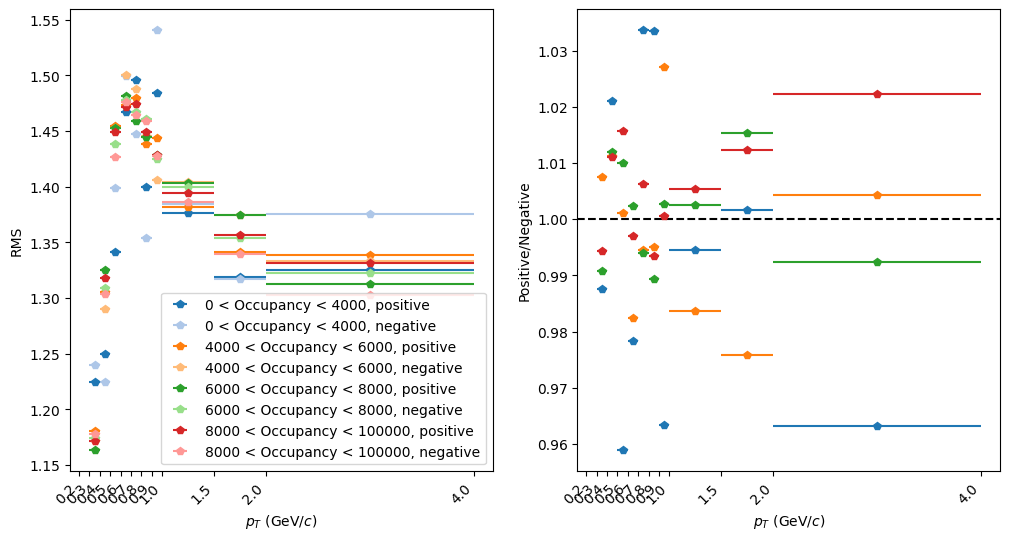

In [31]:
fig_occ_pos_pi = draw_ratio_sigma_pos_neg(occ_dfs_pos_pi_mc, occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi', 'fNSigmaTofNegPi')


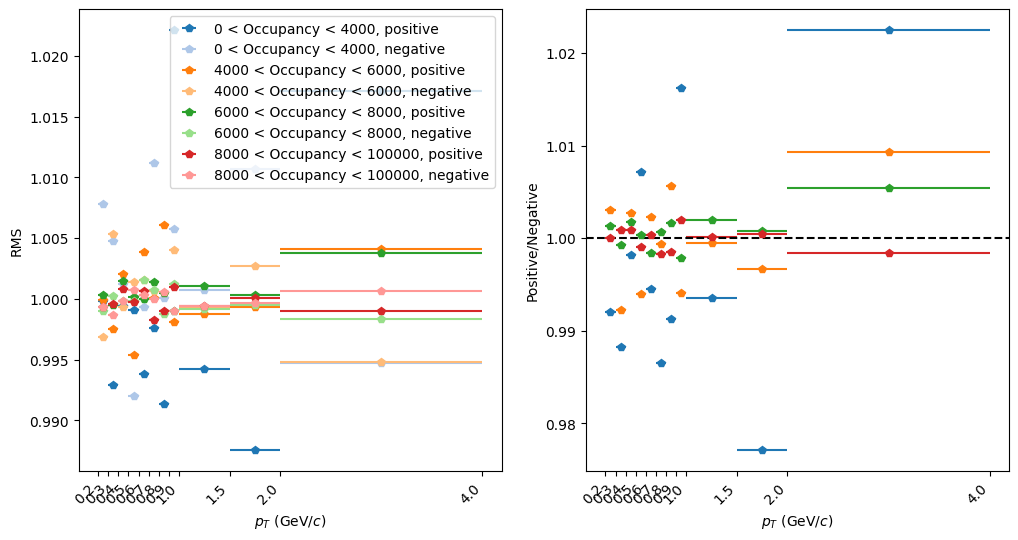

In [32]:
fig_occ_pos_pi = draw_ratio_sigma_pos_neg(occ_dfs_pos_pi_mc, occ_dfs_neg_pi_mc, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi', 'fNSigmaTpcNegPi')


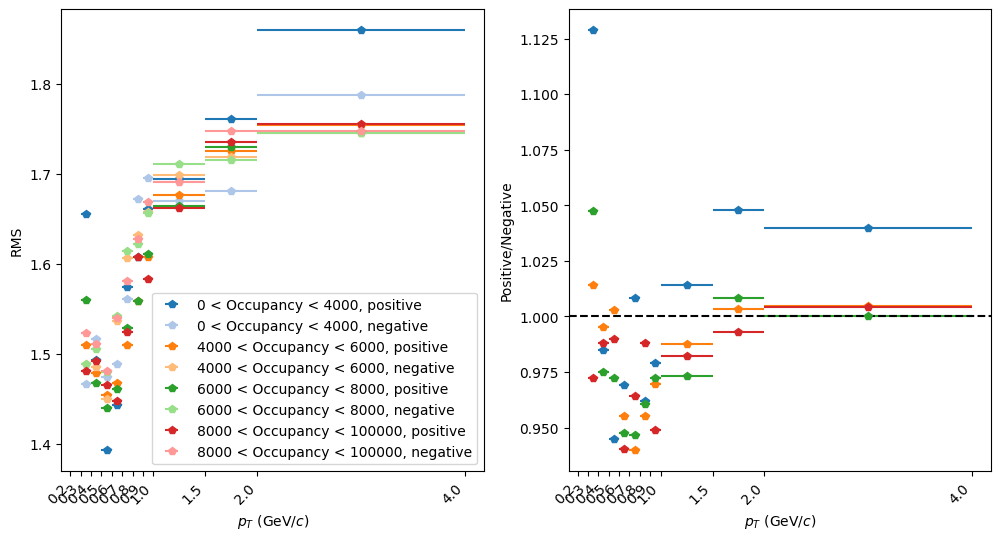

In [33]:
fig_occ_pos_pi = draw_ratio_sigma_pos_neg(occ_dfs_pos_pi, occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTofPosPi', 'fNSigmaTofNegPi')

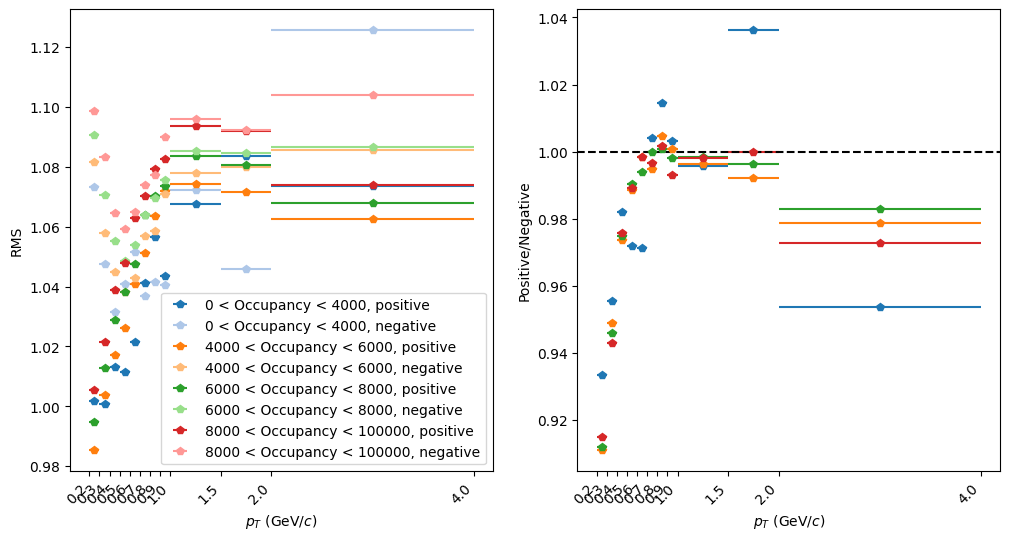

In [34]:
fig_occ_pos_pi = draw_ratio_sigma_pos_neg(occ_dfs_pos_pi, occ_dfs_neg_pi, ['cent_0_50'], 'fPt', labels, 'fNSigmaTpcPosPi', 'fNSigmaTpcNegPi')